In [1]:
import torch
import csv
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
class DigitDataset(Dataset):
    """
    Classe para criar um Dataset a partir do arquivo de entrada
    """

    def __init__(self, path):
        """
        Lê o arquivo de entrada e criar um array numpy
        path: Nome do arquivo de entrada
        """
        self.data = pd.read_csv(path).values.astype(np.float32)

    def __len__(self):
        """
        Retorna o número de entradas
        """
        return self.data.shape[0]

    def __getitem__(self, index):
        """
        Retorna os valores x e y a partir do índice
        index: índice da entrada
        """
        # Formato dos dados: [y[i], x[i,1], x[i,2], ..., x[i,784]]
        data = self.data[index, :]
        x = torch.from_numpy(data[1:]) / 255.0  # Normalizado para valores entre 0 e 1
        y = torch.from_numpy(np.array(data[0]).astype(int))
        return x, y

In [ ]:
class MLP(nn.Module):
    """
    Multilayer Perceptron
    """

    def __init__(self, input=784, oculta=25, output=10):
        """
        Cria as camadas do MLP
        input: Número de dimensões da entrada
        oculta: Número de nurônios da camada oculta
        output: Número de classes da saída
        """
        super(MLP, self).__init__()
        """Camada de Entrada"""
        self.fc1 = nn.Linear(input, oculta)
        """Camada Oculta"""
        self.fc2 = nn.Linear(oculta, output)

    def forward(self, x):
        """Forward Pass"""
        x = F.sigmoid(self.fc1(x))  # Função de ativação Sigmoid
        return F.softmax(self.fc2(x), dim=1)  # Saída por Softmax

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=3, min_delta=0.0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def __call__(self, validation_loss):
        if (validation_loss + self.min_delta) < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif (validation_loss + self.min_delta) > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.tolerance:
                return True
        return False

In [ ]:
def train_one_epoch(model, train_dataloader, loss_func, optimiser):
    model.train()
    epoch_loss = 0.0
    for x, y in train_dataloader:

        optimiser.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_dataloader)
    print(f'Training loss: {epoch_loss}')
    return epoch_loss, y_pred

def validate_one_epoch(model, validate_dataloader, loss_func):
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for x, y in validate_dataloader:
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            epoch_loss += loss.item()
        epoch_loss /= len(validate_dataloader)
    print(f'Validation loss: {epoch_loss}')
    return epoch_loss


In [ ]:
def main(max_epochs=50, batch_size=10, camada_oculta=25, lr=0.5,
         tolerance=3, min_delta=0.05):

    print("Modelo: Camada oculta %3d | Batch Size %4d | LR %2.1f"
          % (camada_oculta, batch_size, lr))

    # Load data
    train_dataset = DigitDataset('data_tp1')
    test_dataset = DigitDataset('validation.csv')
    # Define data loaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    validate_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    # Initialize model
    model = MLP(oculta=camada_oculta)
    loss_func = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=lr)
    train_loss = []
    validation_loss = []
    early_stopping = EarlyStopping(tolerance, min_delta)

    for i in range(max_epochs):
        # training
        print(f"Epoch {i+1}")
        epoch_train_loss, pred = train_one_epoch(model, train_dataloader,
                                                 loss_func, optimiser)
        train_loss.append(epoch_train_loss)

        # validation
        with torch.no_grad():
            epoch_validate_loss = validate_one_epoch(model, validate_dataloader,
                                                     loss_func)
            validation_loss.append(epoch_validate_loss)

        # early stopping
        if i > 0:
            print(f"Loss delta: {validation_loss[i-1] - validation_loss[i]}")
        print('-------------------------------')
        if early_stopping(epoch_validate_loss):
            print(f"We are at epoch: {i+1}")
            break

    return train_loss, validation_loss

In [ ]:
if __name__ == '__main__':
    train_loss, validation_loss = main(camada_oculta=100, min_delta=0.01)

Modelo: Camada oculta 100 | Batch Size   10 | LR 0.5
Epoch 1
Training loss: 2.1253687615394594
Validation loss: 1.967811903726487
Epoch 2
Training loss: 1.8785380322933196
Validation loss: 1.8338063295682272
Loss gain: 0.13400557415825975
Epoch 3
Training loss: 1.773317195415497
Validation loss: 1.7431356896956762
Loss gain: 0.09067063987255097
Epoch 4
Training loss: 1.7328805050849914
Validation loss: 1.7298479284275146
Loss gain: 0.013287761268161669
Epoch 5
Training loss: 1.7192862122058867
Validation loss: 1.726707476150422
Loss gain: 0.003140452277092587
Epoch 6
Training loss: 1.7110492475032806
Validation loss: 1.7179690949973605
Loss gain: 0.00873838115306147
Epoch 7
Training loss: 1.7046698303222656
Validation loss: 1.7131128791968029
Loss gain: 0.004856215800557617
Epoch 8
Training loss: 1.6869451797008514
Validation loss: 1.6726968359379542
Loss gain: 0.04041604325884873
Epoch 9
Training loss: 1.648063901901245
Validation loss: 1.6632233421859286
Loss gain: 0.0094734937520255

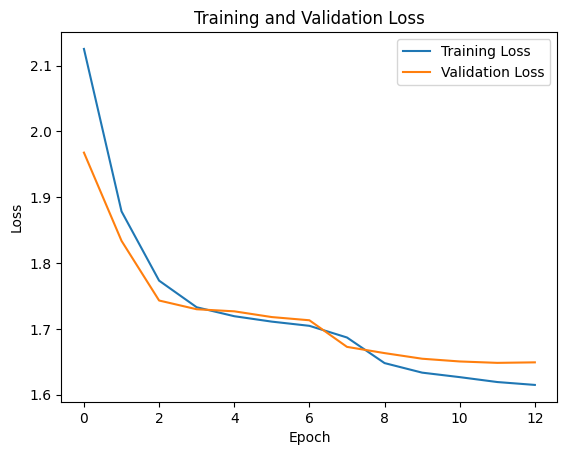

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def test(model=MLP, path="test.csv", batch_size=1000):

    # Load data
    test_data = DigitDataset(path)
    test_loader = DataLoader(test_data, batch_size, shuffle=False)

    # Start test and write the results
    model.eval()
    results = "test_results.csv"
    with open(results, "w") as f:
        fieldnames = ["id", "label"]
        writer = csv.DictWriter(f, fieldnames, lineterminator="\n")
        writer.writeheader()
        id = 1

        with torch.no_grad():
            for input, _ in test_loader:
                output = model(input).argmax(dim=1)
                for label in output:
                    writer.writerow(dict(zip(fieldnames, [id, label.item()])))
                    id += 1

        f.close()

    # Valores reais
    y_real = pd.read_csv(path)["label"].values.astype(np.int8)

    # Valores produzidos pelo modelo
    y_test = pd.read_csv(results)["label"].values.astype(np.int8)

    # Comparação
    num_acertos = (y_real == y_test).sum()
    total = len(y_real)
    taxa_acerto = num_acertos / total
    print("Numero de acertos: %d | Total: %d" % (num_acertos, total))
    print("Taxa de acerto: %3.2f%%" % (taxa_acerto * 100))
    return taxa_acerto

In [ ]:
if __name__ == "__main__":
    params = {
        "camada_oculta": 25,
        "batch_size": 5,
        "path": "data_tp1",
        "num_epochs": 20,
        "lr": 0.5,
    }
    model = train(**params, verbose=True)

Loss after mini-batch   100: 2.299
Loss after mini-batch   200: 2.271
Loss after mini-batch   300: 2.239
Loss after mini-batch   400: 2.206
Loss after mini-batch   500: 2.169
Loss after mini-batch   600: 2.144
Loss after mini-batch   700: 2.120
Loss after mini-batch   800: 2.097
Loss after mini-batch   900: 2.074
Loss after mini-batch  1000: 2.052
Loss after epoch  1: 2.052
--------------------
Loss after mini-batch   100: 1.790
Loss after mini-batch   200: 1.777
Loss after mini-batch   300: 1.779
Loss after mini-batch   400: 1.771
Loss after mini-batch   500: 1.758
Loss after mini-batch   600: 1.747
Loss after mini-batch   700: 1.735
Loss after mini-batch   800: 1.725
Loss after mini-batch   900: 1.714
Loss after mini-batch  1000: 1.707
Loss after epoch  2: 1.707
--------------------
Loss after mini-batch   100: 1.611
Loss after mini-batch   200: 1.608
Loss after mini-batch   300: 1.605
Loss after mini-batch   400: 1.603
Loss after mini-batch   500: 1.600
Loss after mini-batch   600: 

In [ ]:
test(model, "test.csv")

In [ ]:
with open("eval.csv", "w") as f:
    # Criando um arquivo csv com os resultados
    fieldnames = ["hidden_layer", "batch_size", "learning_rate"]
    for i in range(10):
        fieldnames.append(f"taxa_acerto #{i}")
    writer = csv.DictWriter(f, fieldnames, lineterminator="\n")
    writer.writeheader()

    # Hiper-parâmetros
    camadas_ocultas = [25, 50, 100]
    batch_sizes = [1, 10, 50, 100, 500, 1000, 5000]
    learning_rates = [0.1, 0.5, 1.0, 10.0]

    # Todas as combinações de hiper-parâmetros
    for hl in camadas_ocultas:
        for batch in batch_sizes:
            for lr in learning_rates:
                stats = [hl, batch, lr]
                # 10 Valores para cada combinação
                for i in range(10):
                    params = {
                        "camada_oculta": hl,
                        "batch_size": batch,
                        "path": "data_tp1",
                        "num_epochs": 100,
                        "lr": lr,
                        "verbose": False,
                    }
                    model = train(**params)
                    taxa_acerto = test(model)
                    stats.append(taxa_acerto)
                writer.writerow(dict(zip(fieldnames, stats)))

In [ ]:
results = pd.read_csv("eval.csv")
results